### まずは、googleドライブをマウント 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


必要なデータセットをドライブからコピー

In [ ]:
!cp /content/drive/Shareddrives/102_業務委託共有_E資格改修/01_講義スライド/01_作成中/野口/11_自然言語処理分野/コード/transformer/addition.txt .

### ライブラリのインポート

必要なライブラリをインポートします。エラーになる場合は該当するものをインストールしてください。

In [ ]:
import numpy as np
import os,pickle
import matplotlib.pyplot as plt
from gensim.models import word2vec
import gensim.downloader as api
from sklearn.model_selection import train_test_split
# 乱数シードを指定
np.random.seed(seed=0)

### データセット用意

今回用いるデータセットは、足し算の数式を並べたものになります。数式とその答を全て文字列として考えます。

In [ ]:
id_to_char = {}
char_to_id = {}


def _update_vocab(txt):
    chars = list(txt)
    for i, char in enumerate(chars):
        if char not in char_to_id:
            tmp_id = len(char_to_id)
            char_to_id[char] = tmp_id
            id_to_char[tmp_id] = char

def load_sequence(file_name='addition.txt'):
    file_path = './' + file_name
    if not os.path.exists(file_path):
        print('No file: %s' % file_name)
        return None
    questions, answers = [], []

    for line in open(file_path, 'r'):
        idx = line.find('_')
        questions.append(line[:idx])
        answers.append(line[idx:-1])

    # create vocab dict
    for i in range(len(questions)):
        q, a = questions[i], answers[i]
        _update_vocab(q)
        _update_vocab(a)

    # create np array
    x = np.zeros((len(questions), len(questions[0])), dtype=np.int)
    t = np.zeros((len(questions), len(answers[0])), dtype=np.int)

    for i, sentence in enumerate(questions):
        x[i] = [char_to_id[c] for c in list(sentence)]
    for i, sentence in enumerate(answers):
        t[i] = [char_to_id[c] for c in list(sentence)]

    # shuffle
    indices = np.arange(len(x))
    np.random.shuffle(indices)
    x = x[indices]
    t = t[indices]

    # 10% for validation set
    split_at = len(x) - len(x) // 10
    (x_train, x_test) = x[:split_at], x[split_at:]
    (t_train, t_test) = t[:split_at], t[split_at:]
    return (x_train, t_train), (x_test, t_test)

def get_vocab():
    return char_to_id, id_to_char

In [ ]:
(x_train, t_train), (x_test, t_test) = load_sequence('addition.txt')
char_to_id, id_to_char = get_vocab()

In [ ]:
print(char_to_id)
print(id_to_char)

{'1': 0, '6': 1, '+': 2, '7': 3, '5': 4, ' ': 5, '_': 6, '9': 7, '2': 8, '0': 9, '3': 10, '8': 11, '4': 12}
{0: '1', 1: '6', 2: '+', 3: '7', 4: '5', 5: ' ', 6: '_', 7: '9', 8: '2', 9: '0', 10: '3', 11: '8', 12: '4'}


## 基本的関数、アルゴリズムの実装

<font color="Red">※誤差逆伝播を実装するためには、backwardメソッドを用意する必要があるが、シラバスの範囲外であるので、forward(順伝播)のみの実装である</font>

- softmax
- relu
- MatMul: 行列積
- Dropout
- Norm: 正規化


In [ ]:
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))
    return x

In [ ]:
class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        self.out = softmax(x)
        return self.out

In [ ]:
def relu(x):
    return np.maximum(0, x)

In [ ]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

In [ ]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

In [ ]:
class Dropout:
    '''
    http://arxiv.org/abs/1207.0580
    '''
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

In [ ]:
class Norm:
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
    
        self.size = d_model
        self.alpha = np.ones(self.size)
        self.bias = np.zeros(self.size)
        self.eps = eps

    def forward(self, x):
        std_eps = np.std(x, axis=0, keepdims=True) + self.eps
        norm = self.alpha * (x - np.mean(x, axis=0, keepdims=True)) / std_eps + self.bias
        return norm

## 各種クラス定義

<font color="Red">※誤差逆伝播を実装するためには、backwardメソッドを用意する必要があるが、シラバスの範囲外であるので、forward(順伝播)のみの実装である</font>

ネットワークに必要なクラスを定義

### Embedding クラス

In [ ]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

### TimeEmbedding クラス

In [ ]:
class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

    def forward(self, xs):
        N, T = xs.shape
        V, D = self.W.shape
        out = np.empty((N, T, D), dtype='f')
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)
        return out

### Affine クラス

In [ ]:
class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out

### TimeAffine クラス

In [ ]:
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params
        out = np.matmul(x, W) + b
        self.x = x
        return out.reshape(N, T, -1)

## Transformerに必要なクラス定義

 ### Trannsformerアーキテクチャ

 Transformer実装に必要な機能を確認

 - Positional encodingクラス
 - Creating masks関数
 - Multi Head Attentionクラス
 - Feed Forwardクラス
 - Encoder Layerクラス
 - Decoder Layerクラス
 - clone関数


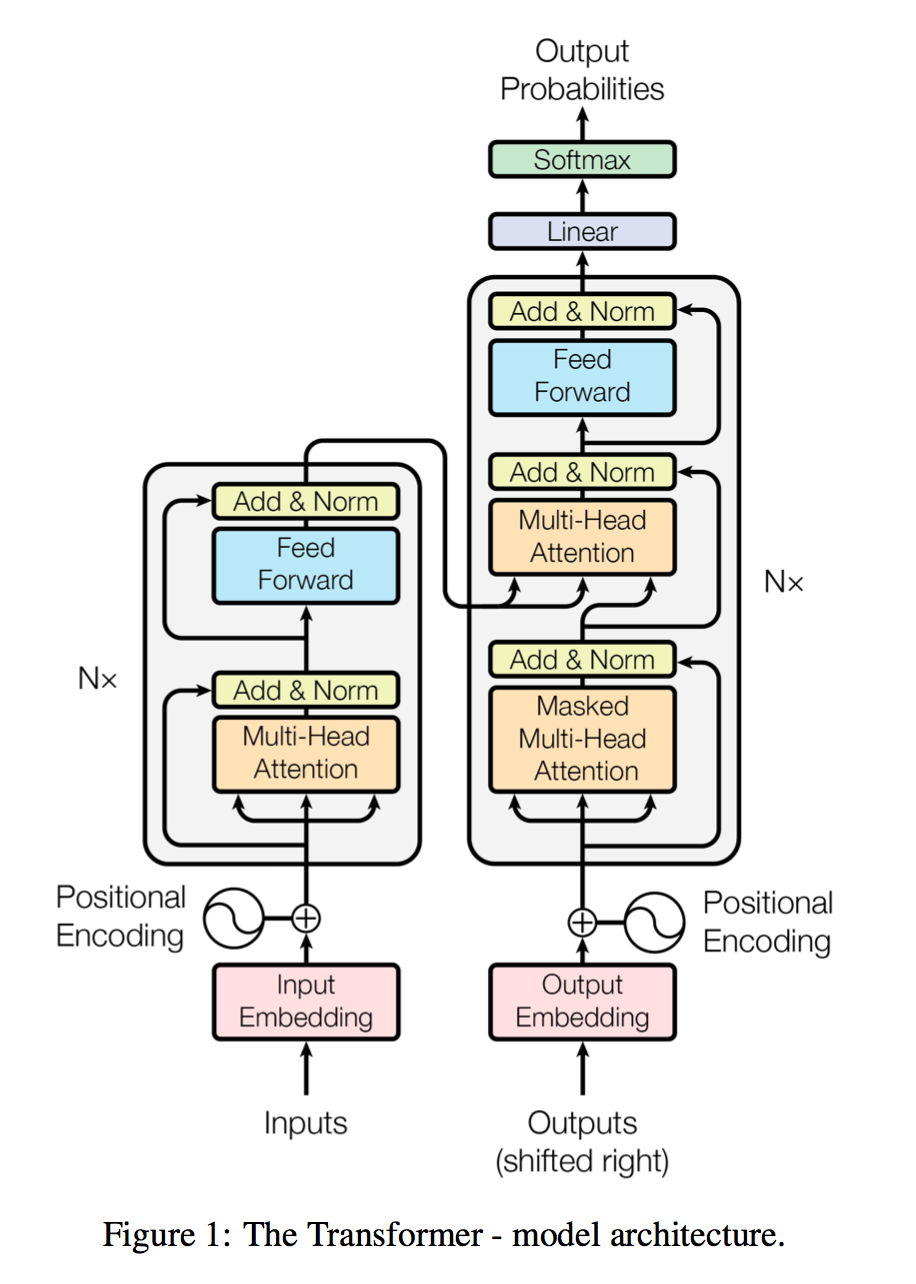

### Positional encodingクラス

TransformerはRNNやCNNを使用しないので、単語列の語順 (単語の相対的または絶対的な位置) の情報を追加する必要がある。

そこで、Embeddingクラスの出力に位置エンコーディング (Positional Encoding)の出力を要素ごとに加算する。

位置エンコーディングの出力は行列PEで、その各要素は以下のように表される。

posは単語の位置，iは成分の次元、dmodelはモデルの次元である。

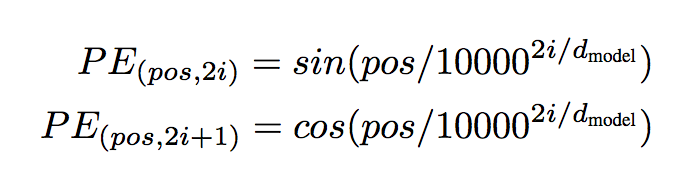

**initメソッド**

initメソッドでは、位置エンコーディング行列PEを定義する。
`torch.zeros`で零テンソルを作り、各要素を上式の値に書き換えるという単純なものである。


forwardメソッド

forwardメソッドでは、Embeddingクラスの出力にPEを足し合わせる処理を行う。

In [ ]:
class PositionalEncoder:
    def __init__(self, d_model, max_seq_len = 80):
        super().__init__()
        self.d_model = d_model        
        pe = np.zeros((max_seq_len, d_model))
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = np.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = np.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))                
        self.pe = np.array([pe])
    
    def forward(self, x):
        x = x * np.sqrt(self.d_model)
        seq_len = x.shape[1]
        x = x + self.pe[:, :seq_len]
        return x

### Creating Masks関数

パディングの`<pad>`部分は何の意味も持たないため、Attentionする必要が無い。

そのため、ここではパディングした`<pad>`部分にマスク処理を施し、Attention weightが0になるようにする。

これが`input_mask`と`target_mask`に保存される。

また、`np.triu`で上三角行列を取得することで、予測時点より未来の情報が0になるので、未来の情報がマスクされた状態になる。

これが`nopeak_mask`以降に保存される。

In [ ]:
def create_masks(input_seq, target_seq, char_to_id):
    pad_id = char_to_id[' ']
    input_msk = np.array([input_seq != pad_id]).transpose(1, 0, 2)
    target_msk = np.array([target_seq != pad_id]).transpose(1, 0, 2)

    size = target_seq.shape[1] # get seq_len for matrix
    nopeak_mask = np.triu(np.ones((1, size, size)), k=1).astype(np.uint8) == 0
    target_msk = target_msk & nopeak_mask
    
    return input_msk, target_msk

### Multi-head Attentionクラス

#### 単一のattention関数を定義

`q_linear`と`k_linear`がAttentionのqueryとkeyに相当するので、これを`np.matmul`で掛け算する。

掛け算の結果をsoftmax関数で確率に変換して、さらに`v_linear`と掛け合わせることで、Attentionされたベクトルが得られる。

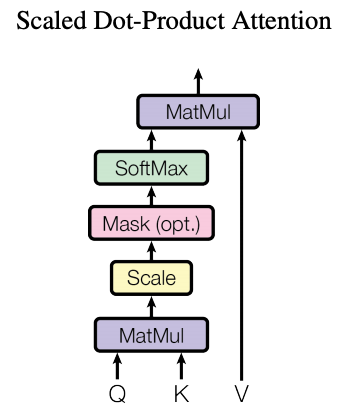

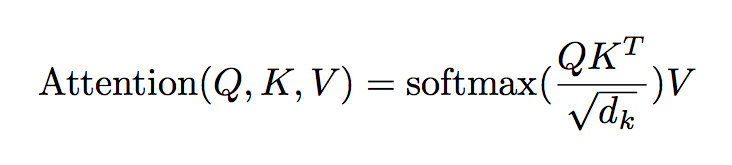

In [ ]:
def attention(q, k, v, d_k, mask=None, dropout=None):
    scores = np.matmul(q, k.transpose(0, 2, 1)) / np.sqrt(d_k)
    if mask is not None:
        scores[mask.astype('int') == 0] = -1e9
    scores = softmax(scores)

    if dropout is not None:
        scores = dropout.forward(scores)  # 過学習を抑えるためにdropout層
    
    output = np.matmul(scores, v)
    return output

#### Attentionの多層化

query,key,valueをそれぞれ`np.spilit`でheadごとに分割して、headごとのAttentionの出力を`np.concatenate`で結合する。

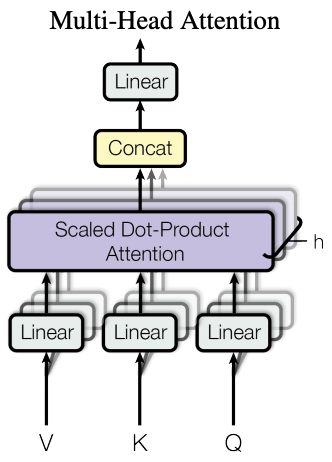

In [ ]:
class MultiHeadAttention:
    def __init__(self, heads, d_model, dropout = 0.1):
        rn = np.random.randn

        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        
        W_q = (rn(d_model, d_model) / np.sqrt(d_model)).astype('f')
        W_v = (rn(d_model, d_model) / np.sqrt(d_model)).astype('f')
        W_k = (rn(d_model, d_model) / np.sqrt(d_model)).astype('f')
        out_W = (rn(d_model, d_model) / np.sqrt(d_model)).astype('f')

        self.q_linear = MatMul(W_q)
        self.v_linear = MatMul(W_v)
        self.k_linear = MatMul(W_k)
        self.dropout = Dropout(dropout)
        self.out = MatMul(out_W)

    
    def forward(self, q, k, v, mask=None):
        
        bs = q.shape[0]
        k = self.k_linear.forward(k).reshape(bs, -1, self.h, self.d_k)
        k_heads = np.split(k, self.h, 2)  # heads(attentionの数ごとに分割)
        q = self.q_linear.forward(q).reshape(bs, -1, self.h, self.d_k)
        q_heads = np.split(q, self.h, 2)  # heads(attentionの数ごとに分割)
        v = self.v_linear.forward(v).reshape(bs, -1, self.h, self.d_k)
        v_heads = np.split(v, self.h, 2)  # heads(attentionの数ごとに分割)

        scores = []
        for q, k, v in zip(q_heads, k_heads, v_heads):
            q = np.squeeze(q)
            k = np.squeeze(k)
            v = np.squeeze(v)
            scores.append(attention(q, k, v, self.d_k, mask, self.dropout))

        concat = np.concatenate(scores, 2).reshape(bs, -1, self.d_model)        
        output = self.out.forward(concat)
    
        return output

### FeedForwardクラス

このクラスはPosition-wise Feed-Forward Networkと呼ばれる。

単語の位置ごとに情報を伝搬させるネットワークである。

${\rm FFN}(x)={\rm ReLU}(xW_1+b_1)W_2+b_2$

線形ニューラルネットワーク→ReLU→線形ニューラルネットワークと学習させる。

In [ ]:
class FeedForward:
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        rn = np.random.randn
        
        linear_1_W = (rn(d_model, d_ff) / np.sqrt(d_model)).astype('f')
        linear_1_b = np.zeros(d_ff).astype('f')
        linear_2_W = (rn(d_ff, d_model) / np.sqrt(d_model)).astype('f')
        linear_2_b = np.zeros(d_model).astype('f')

        self.linear_1 = TimeAffine(linear_1_W, linear_1_b)
        self.relu = Relu()
        self.dropout = Dropout(dropout)
        self.linear_2 = TimeAffine(linear_2_W, linear_2_b)

    def forward(self, x):
        x = self.dropout.forward(self.relu.forward(self.linear_1.forward(x)))
        x = self.linear_2.forward(x)
        return x

Transformerのアーキテクチャ再掲

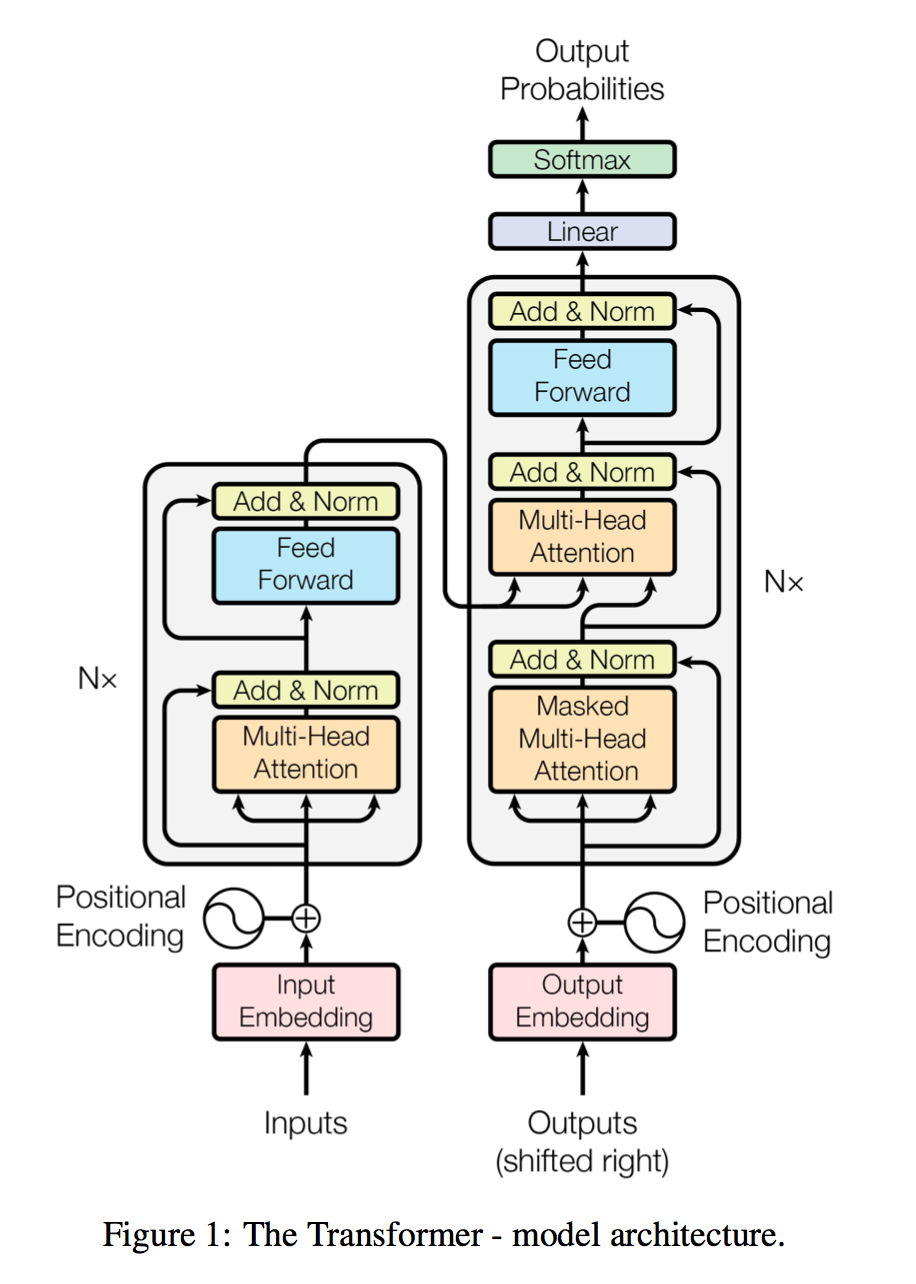

### EncoderLayerクラス(Encoderの一層)

 Encoder側の灰色部分(N個重ねるブロック)の実装

1. 入力をattentionに通し、さらにdropoutする

2. 1.の結果をもとの入力に足し合わせる(attentionの情報を付加)

3. 2.の結果を正規化する

4. 3.の結果をFeedForwardクラスに通し、さらにdropoutする

5. 4.の結果を3.の結果に足し合わせる(Feed-Forwardの情報を付加)

6. 5.の結果を正規化する

※正規化レイヤの位置は2通りある。今回は後者

- attentionやfeed forwardの前
- attentionやfeed forwardの後

In [ ]:
class EncoderLayer:
    def __init__(self, d_model, heads, dropout = 0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model, d_ff=64)
        self.dropout_1 = Dropout(dropout)
        self.dropout_2 = Dropout(dropout)
        
    def forward(self, x, mask):
        if mask is not None:
            mask = np.repeat(mask, x.shape[1], axis=1)  # 後の計算のため、時系列方向を拡張

        attn_x = self.dropout_1.forward(self.attn.forward(x, x, x, mask))  # Multi Head Attention
        x = self.norm_1.forward(x + attn_x)  # add & norm
        attn_x = self.dropout_2.forward(self.ff.forward(x))  # feed forward
        x = self.norm_2.forward(x + attn_x)  # add & norm
        return x

### DecoderLayerクラス(Decoderの一層)

 Decoder側の灰色部分(N個重ねるブロック)の実装

1. 【Self Attention】入力をattentionに通し、さらにdropoutする

2. 1.の結果を元の入力に足し合わせる(Self Attentionの情報を付加)

3. 2.の結果を正規化する

4. 【Source-Target Attention】3.の結果をqueryとして、エンコーダの出力をkeyとvalueとしてattentionに通し、さらにdropoutする。

5. 4.の結果を3.の結果に足し合わせる(Source-Target Attentionの情報を付加)

6. 5.の結果を正規化する

7. 6.の結果をFeedForwardクラスに通し、さらにdropoutする

8. 7.の結果を6.の結果に足し合わせる(Feed-Forwardの情報を付加)

9. 8.の結果を正規化する

In [ ]:
class DecoderLayer:
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)
        
        self.dropout_1 = Dropout(dropout)
        self.dropout_2 = Dropout(dropout)
        self.dropout_3 = Dropout(dropout)
        
        self.attn_1 = MultiHeadAttention(heads, d_model)
        self.attn_2 = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model, d_ff=64)

    def forward(self, x, e_outputs, src_mask, trg_mask):
        if src_mask is not None:
            src_mask = np.repeat(src_mask, trg_mask.shape[-1], axis=1)  # 後の計算のため、時系列方向を拡張

        attn_x = self.dropout_1.forward(self.attn_1.forward(x, x, x, trg_mask))  # Multi Head Attention
        x = self.norm_1.forward(x + attn_x)  # add & norm
        attn_x = self.dropout_2.forward(self.attn_2.forward(x, e_outputs, e_outputs, src_mask))  # Multi Head Attention
        x = self.norm_2.forward(x + attn_x)  # add & norm
        ff_x = self.dropout_3.forward(self.ff.forward(x))  # feed forward
        x = self.norm_3.forward(x + ff_x)  # add & norm
        return x

### clone関数

EncoderLayerやDecoderLayerをそれぞれN層組み合わせるための関数

In [ ]:
def get_clones(module, N):
    return [module for i in range(N)]

### Encoderクラス

1. 単語埋め込み

2. positional encoding

3. EncoderLayarクラスをN回繰り返す

In [ ]:
class Encoder:
    def __init__(self, vocab_size, d_model, N, heads):
        rn = np.random.randn
        # パラメータ
        self.N = N
        embed_W = (rn(vocab_size, d_model) / 100).astype('f')
        # レイヤ（ブロック）
        self.embed = TimeEmbedding(embed_W)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(EncoderLayer(d_model, heads), N)

    def forward(self, src, mask):
        x = self.embed.forward(src)  # 単語埋め込み
        x = self.pe.forward(x)  # positional encoding
        for enc_layer in self.layers:
            x = enc_layer.forward(x, mask)  # encoder layarを繰り返す
        return x

### Decoderクラス

1. 単語埋め込み

2. positional encoding

3. DecoderLayarクラスをN回繰り返す

In [ ]:
class Decoder:
    def __init__(self, vocab_size, d_model, N, heads):
        rn = np.random.randn
        # パラメータ
        self.N = N
        embed_W = (rn(vocab_size, d_model) / 100).astype('f')
        # レイヤ（ブロック） 
        self.embed = TimeEmbedding(embed_W)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(DecoderLayer(d_model, heads), N)

    def forward(self, trg, e_outputs, src_mask, trg_mask):
        x = self.embed.forward(trg)  # 単語埋め込み
        x = self.pe.forward(x)  # positional encoding
        for dec_layer in self.layers:
            x = dec_layer.forward(x, e_outputs, src_mask, trg_mask)  # decoder layarを繰り返す
        return x

### Transformerクラス

1. Encoderクラス

2. Decoderクラス

3. 全結合層

4. softmax

In [ ]:
class Transformer:
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads):
        rn = np.random.randn
        self.encoder = Encoder(src_vocab, d_model, N, heads)
        self.decoder = Decoder(trg_vocab, d_model, N, heads)
        out_W = (rn(d_model, trg_vocab) / np.sqrt(d_model)).astype('f')
        self.out = MatMul(out_W)
        self.softmax = Softmax()

    def forward(self, src, trg, src_mask, trg_mask):
        e_outputs = self.encoder.forward(src, src_mask)
        d_output = self.decoder.forward(trg, e_outputs, src_mask, trg_mask)
        output = self.out.forward(d_output)  # Linear layer（全結合層）
        probas = self.softmax.forward(output)  # softmaxに通す
        return probas

## 順伝播

モデルにデータを流す

In [ ]:
D_MODEL = 16  # 隠れ層の次元
HEADS = 4  # Attentionの数
N = 3  # EncoderおよびDecoderの数

src_vocab = len(id_to_char)
trg_vocab = len(id_to_char)

model = Transformer(src_vocab, trg_vocab, D_MODEL, N, HEADS)

In [ ]:
src = x_train[:100]  # バッチサイズ100
trg = t_train[:100]
trg_input = trg[:, :-1]  # デコーダの入力
targets = trg[:, 1:]  # 正解データ

src_mask, trg_mask = create_masks(src, trg_input, char_to_id)
preds = model.forward(src, trg_input, src_mask, trg_mask)

In [ ]:
print(preds.shape)  # (100, 4, 13) = (バッチ数, 予測対象の時系列(今回：足し算の答えの文字列数), 語彙数(今回：'0'-'9' + '+' + ' ' + '_'))

(100, 4, 13)
